<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
# importing the python packages frequently used
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Loading the data

house = pd.read_csv('./housing.csv')

In [3]:
house.shape

(1460, 81)

In [4]:
house['MSZoning'].value_counts()

# note: there are 10 rows of non-residential to drop

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [5]:
# dropping all non-residential

house_nr = house[house['MSZoning'] == 'C (all)']
house = house.drop(house_nr.index)

In [6]:
# checking the new shape after dropping non-residential rows

print house.shape

(1450, 81)


In [7]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-n

In [8]:
house.isnull().sum().sort_values(ascending=False)
# drop MiscFeature, Id

PoolQC           1443
MiscFeature      1398
Alley            1361
Fence            1172
FireplaceQu       681
LotFrontage       259
GarageCond         79
GarageType         79
GarageYrBlt        79
GarageFinish       79
GarageQual         79
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
Utilities           0
YearRemodAdd        0
MSSubClass          0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearBuilt           0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

In [9]:
# dropping Id column as we do not need for EDA and modelling

house.drop('Id', axis=1, inplace=True)

In [10]:
# looking at the first 5 rows of the dataset

house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
# looking at last 5 rows of the dataset

house.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [12]:
house.columns[house.dtypes != 'object'].values

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'], dtype=object)

In [13]:
house.columns[house.dtypes == 'object'].values

array(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'], dtype=object)

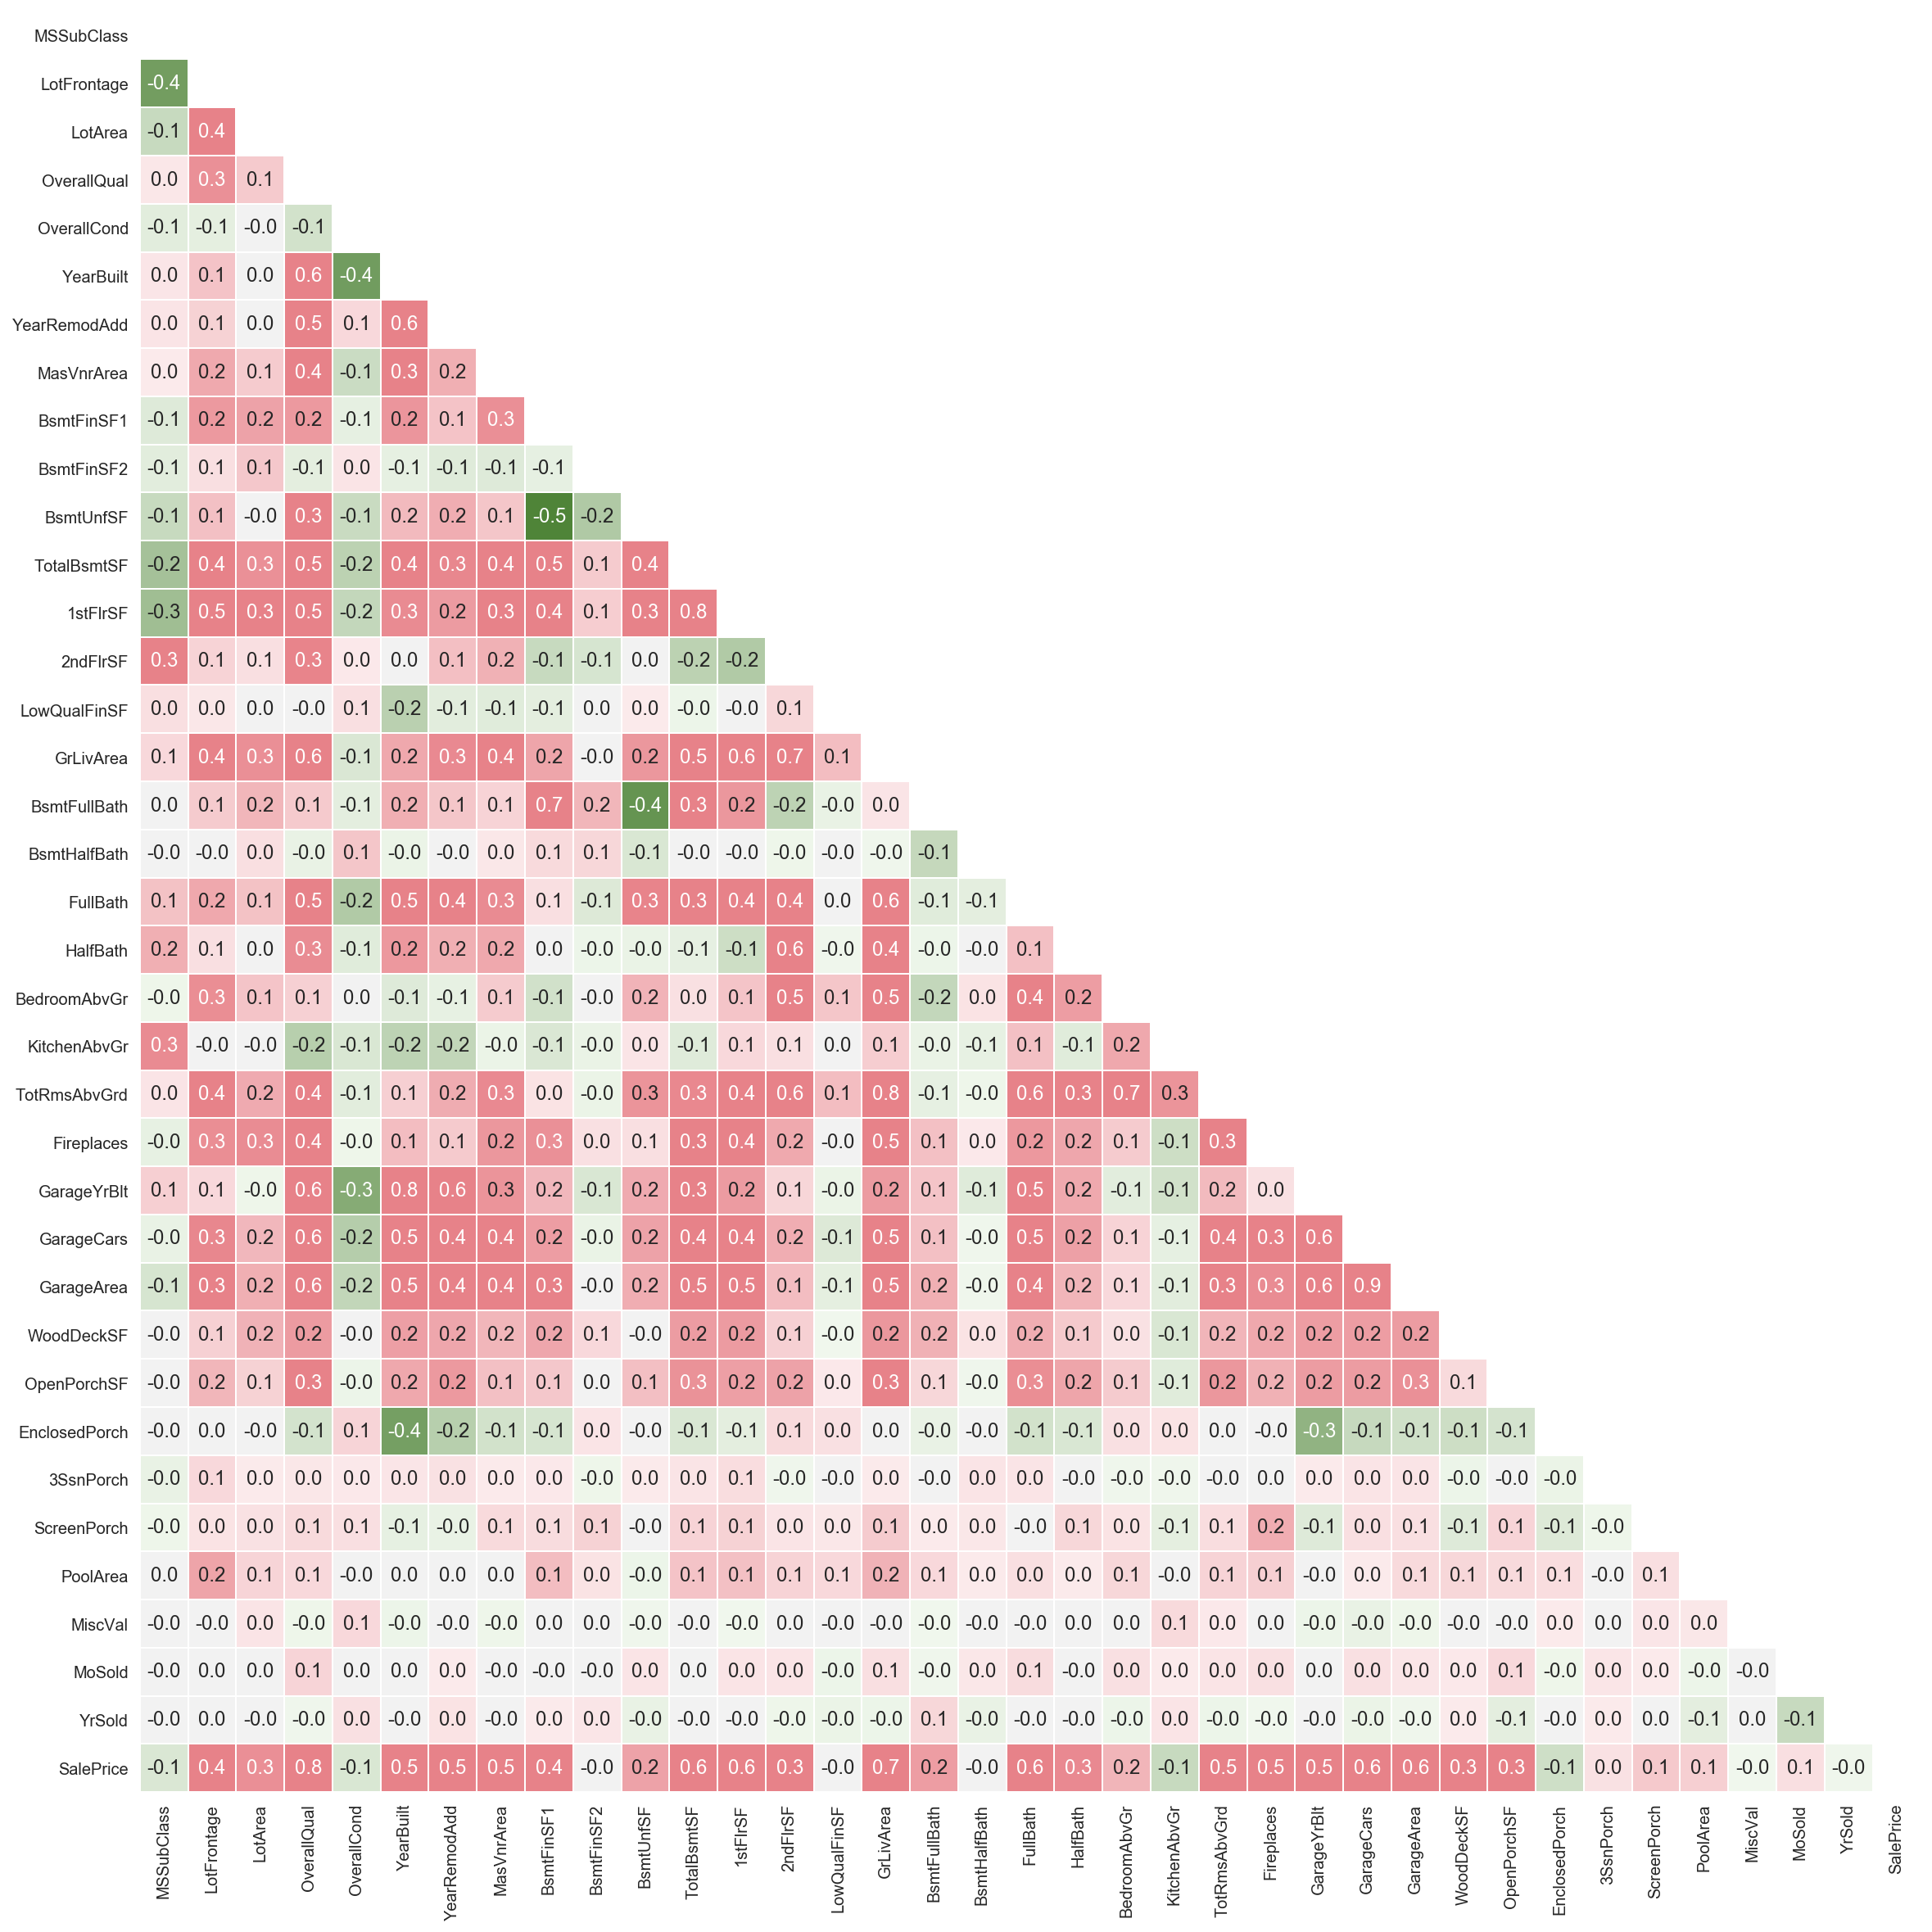

In [14]:
# checking the correlation of columns in the dataset
sns.set(style="white")
corr = house.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(120, 10, as_cmap=True)
plt.figure(figsize=(35,20))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt='.1f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, cbar=False)

In [15]:
# looking at the correlation of features against our target variable

corr=house.corr()["SalePrice"]
corr[np.argsort(corr, axis=0)[::-1]]

SalePrice        1.000000
OverallQual      0.789031
GrLivArea        0.708658
GarageCars       0.642135
GarageArea       0.629831
TotalBsmtSF      0.612088
1stFlrSF         0.603300
FullBath         0.556674
TotRmsAbvGrd     0.533355
YearBuilt        0.517602
YearRemodAdd     0.501186
GarageYrBlt      0.486058
MasVnrArea       0.475950
Fireplaces       0.463264
BsmtFinSF1       0.384475
LotFrontage      0.354848
OpenPorchSF      0.329491
WoodDeckSF       0.320770
2ndFlrSF         0.319774
HalfBath         0.280882
LotArea          0.264715
BsmtFullBath     0.224054
BsmtUnfSF        0.216152
BedroomAbvGr     0.162008
ScreenPorch      0.110540
PoolArea         0.092396
MoSold           0.051987
3SsnPorch        0.043807
BsmtFinSF2      -0.014145
BsmtHalfBath    -0.017561
LowQualFinSF    -0.018755
MiscVal         -0.021052
YrSold          -0.025391
MSSubClass      -0.087487
OverallCond     -0.089084
EnclosedPorch   -0.120765
KitchenAbvGr    -0.137825
Name: SalePrice, dtype: float64

In [16]:
# sorting our features to 3 categories - non-numeric categorical features, numeric ordinal features and numeric non-categorical featuers


# categorical features, non-numeric

house_cat = house[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'SaleType', 'SaleCondition', 'MSSubClass', 'MiscFeature']]


# not categorical, but numerical features

house_num = house[['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice']]


# categorical, ordinal values

house_ord = house.drop(house_cat, axis=1)
house_ord = house_ord.drop(house_num, axis=1)

In [17]:
house_ord.columns.values

array(['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars'], dtype=object)

In [18]:
# checking our total columns in 3 new DFs have the same number as house DF

print house_ord.shape
print house_num.shape
print house_cat.shape

(1450, 11)
(1450, 25)
(1450, 44)


We will check for the NaN values in our 3 new DFs and fill them up accordingly before EDA and modelling.

In [19]:
house_cat.isnull().sum().sort_values(ascending=False)

PoolQC           1443
MiscFeature      1398
Alley            1361
Fence            1172
FireplaceQu       681
GarageCond         79
GarageQual         79
GarageFinish       79
GarageType         79
BsmtFinType2       38
BsmtExposure       38
BsmtCond           37
BsmtFinType1       37
BsmtQual           37
MasVnrType          8
Electrical          1
RoofStyle           0
Street              0
SaleCondition       0
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofMatl            0
CentralAir          0
Exterior1st         0
Exterior2nd         0
ExterQual           0
ExterCond           0
Foundation          0
MSSubClass          0
SaleType            0
PavedDrive          0
Functional          0
KitchenQual         0
Heating             0
HeatingQC           0
MSZoning            0
dtype: int64

In [20]:
# Ok to change NaN to 'Nil' as further check shows they mean variable is not available at property

house_cat.fillna('Nil', inplace=True)

C:\Users\Arsyad\Anaconda2\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [21]:
house_num.isnull().sum().sort_values(ascending=False).head()

LotFrontage     259
GarageYrBlt      79
MasVnrArea        8
LowQualFinSF      0
LotArea           0
dtype: int64

In [22]:
# dropping GarageYrBlt as it has high correlation with YearBuilt. We will not be dropping 79 rows . It does not make sense to put 0 for houses with no garage
# as col is showing as year

house_num.drop('GarageYrBlt', axis=1, inplace=True)

C:\Users\Arsyad\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
# filling LotFrontage as 0. Would indicate that there is no LotFrontage

house_num.fillna(0, inplace=True)

In [24]:
house_num.isnull().sum()

LotFrontage      0
LotArea          0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SalePrice        0
dtype: int64

In [25]:
house_num.describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1450.00000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,57.54000,10523.831724,1971.593103,1985.049655,103.828276,445.162759,46.870345,567.375862,1059.408966,1164.773103,...,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517,6.312414,2007.812414,181654.942069
std,34.71992,10012.185355,30.022696,20.552319,181.150114,456.353871,161.828458,442.584978,439.207322,386.646095,...,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495,2.698244,1.326321,79176.485241
min,0.00000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,41.25000,7544.500000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,796.000000,882.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,63.00000,9496.000000,1973.000000,1994.000000,0.000000,384.000000,0.000000,475.000000,992.000000,1088.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163945.000000
75%,79.00000,11613.500000,2001.000000,2004.000000,166.000000,713.750000,0.000000,808.000000,1301.500000,1392.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,313.00000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [26]:
house_ord.isnull().sum()

# no null values to change for house_ord

OverallQual     0
OverallCond     0
BsmtFullBath    0
BsmtHalfBath    0
FullBath        0
HalfBath        0
BedroomAbvGr    0
KitchenAbvGr    0
TotRmsAbvGrd    0
Fireplaces      0
GarageCars      0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F797710>,
      dtype=object)

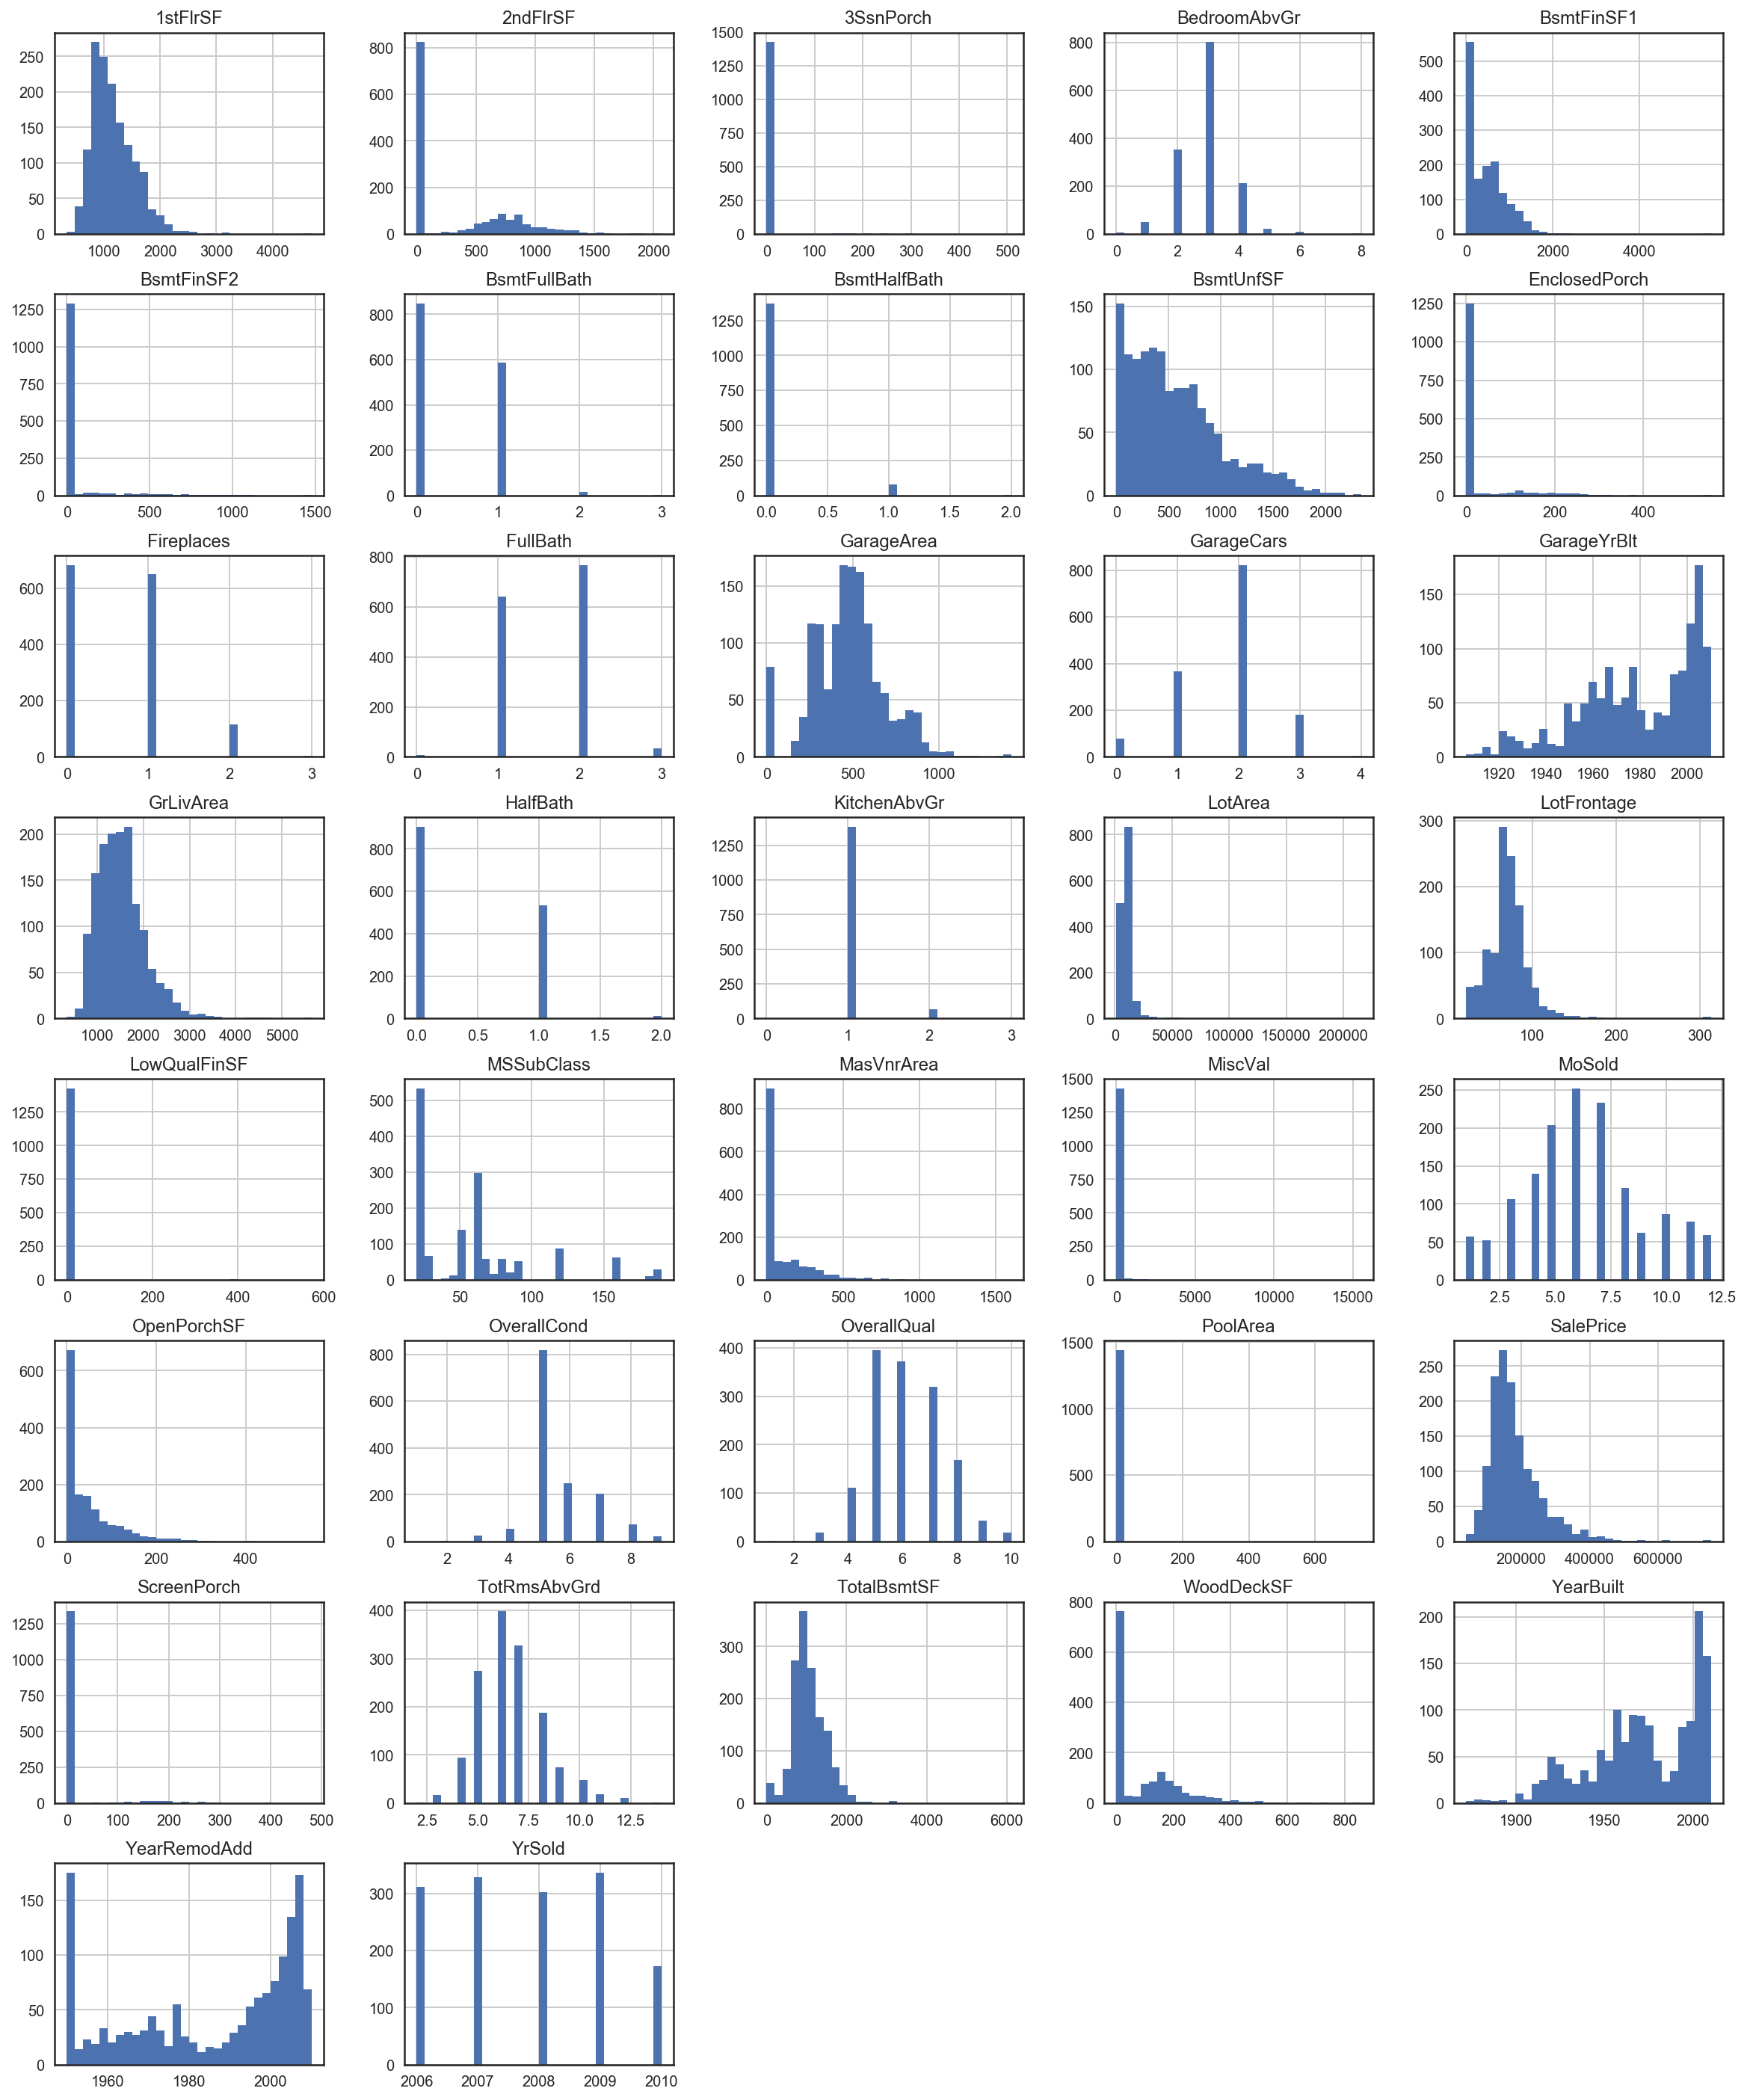

In [27]:
# see distribution of numerical features

plt.figure()
house.hist(layout=(8,5), bins=30, figsize=(20,25))

# SalePrice is slightly skewed to the right. Note: may need to apply log function during regression

In [163]:
# concatenating our cleaned 3 DFs into a new clean DF

house_clean = pd.concat([house_num, house_cat, house_ord], axis=1)

In [29]:
house_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 79 columns):
LotFrontage      1450 non-null float64
LotArea          1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
MasVnrArea       1450 non-null float64
BsmtFinSF1       1450 non-null int64
BsmtFinSF2       1450 non-null int64
BsmtUnfSF        1450 non-null int64
TotalBsmtSF      1450 non-null int64
1stFlrSF         1450 non-null int64
2ndFlrSF         1450 non-null int64
LowQualFinSF     1450 non-null int64
GrLivArea        1450 non-null int64
GarageArea       1450 non-null int64
WoodDeckSF       1450 non-null int64
OpenPorchSF      1450 non-null int64
EnclosedPorch    1450 non-null int64
3SsnPorch        1450 non-null int64
ScreenPorch      1450 non-null int64
PoolArea         1450 non-null int64
MiscVal          1450 non-null int64
MoSold           1450 non-null int64
YrSold           1450 non-null int64
SalePrice        1450 non-null int64
M

In [30]:
# we will need to convert MSSubClass column to object value for categorizing the different type of dwelling.

house_clean['MSSubClass'] = house_clean['MSSubClass'].apply(lambda x: str(x))

In [31]:
# get age of house

house_clean['house_age'] = house_clean['YrSold'] - house_clean['YearBuilt']

In [32]:
# determining the fixed features

# YearRemodAdd, YearBuilt, house_age

fixed_feat = house_clean[['MSSubClass', 'Street', 'LotConfig', 'Condition2', 'Foundation', 'HalfBath',
                   'MSZoning', 'BldgType', 'BsmtQual', 'BsmtFullBath', 'BedroomAbvGr', 'GarageType', 'PoolArea', 
                    'LotFrontage', 'Neighborhood', 'HouseStyle', 'TotalBsmtSF', 'BsmtHalfBath', 'KitchenAbvGr', 
                    'MiscFeature', 'LotShape', 'LandContour', 'Condition1', 'MasVnrType', '2ndFlrSF', 'TotRmsAbvGrd',
                   '1stFlrSF', 'FullBath', 'GrLivArea', 'GarageArea', 'MiscVal', 'LotArea', 'Utilities', 'GarageCars',
                   'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'Alley', 'LandSlope', 'house_age', 'YearRemodAdd',
                    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'RoofStyle', 'Fireplaces'
                         ]]

In [33]:
# creating dummy variable for categories cols

fixed_feat_dummy = pd.get_dummies(fixed_feat, drop_first=True)
fixed_feat_dummy.shape

(1450, 139)

In [34]:
house_1 = pd.concat([fixed_feat_dummy, house['YrSold'], house['SalePrice']], axis=1)
print house_1.shape

(1450, 141)


Text(0.5,1,u'Plot of House Area (in sqft) vs Sale Price')

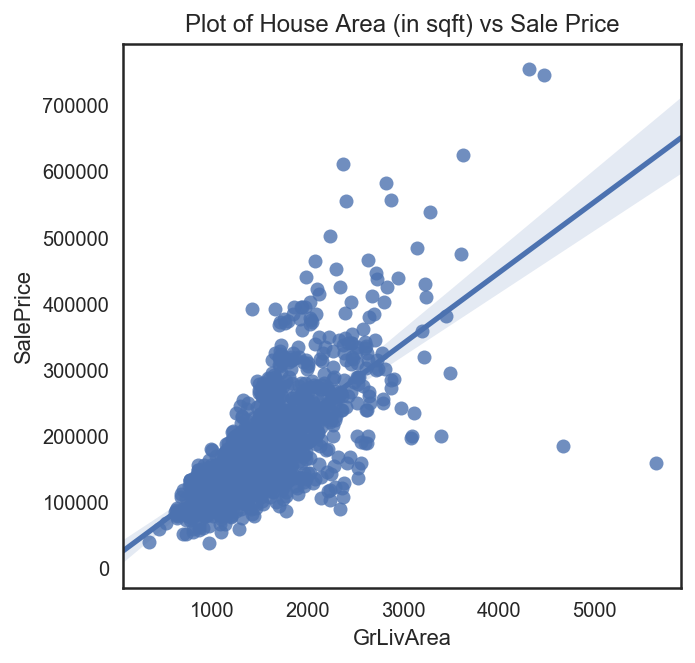

In [35]:
# see relation of sqft with SalePrice

plt.figure(figsize=(5,5))
sns.regplot('GrLivArea', 'SalePrice', house_1)
plt.title('Plot of House Area (in sqft) vs Sale Price')

We see that most of the houses are below 4,000 sqft. <br>
Generally, we see that a bigger house will be priced higher.

Text(0.5,1,u'Plot of House Age vs Sale Price')

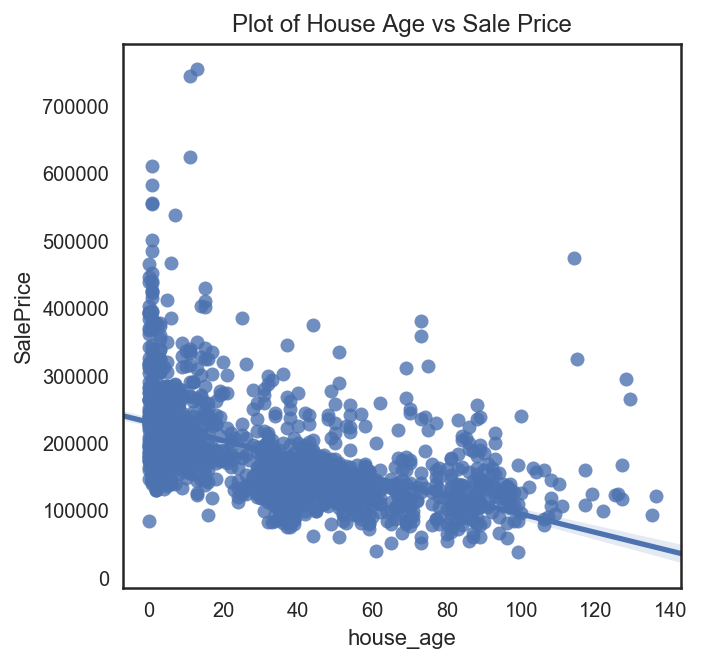

In [36]:
# see relation of house_age with SalePrice
plt.figure(figsize=(5,5))
sns.regplot('house_age', 'SalePrice', house_1)
plt.title('Plot of House Age vs Sale Price')

We see that the houses in our dataset are between 0 - 140 years. 
Generally, we see the price of a house will decrease as it ages.

Text(0.5,1,u'Plot of Garage Area (in sqft) vs Sale Price')

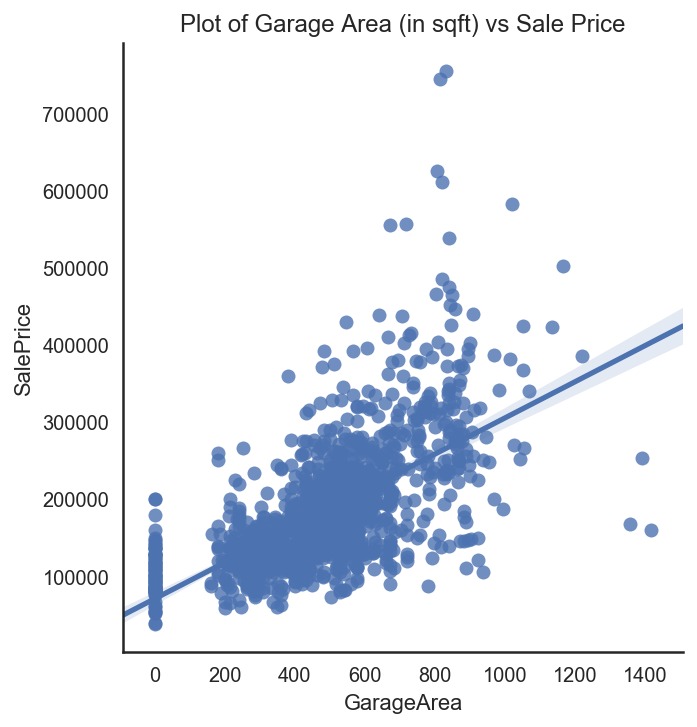

In [37]:
# see relation of Garage Area with SalePrice
plt.figure(figsize=(1,1))
sns.lmplot('GarageArea', 'SalePrice', house_1)
plt.title('Plot of Garage Area (in sqft) vs Sale Price')

We see that the houses in our dataset have garage space up till 1400 sqft. There are also houses with no garage. <br>
Generally, we see that a bigger house will be priced higher. <br>
However, there are houses without garage priced higher than houses with garage.

Text(0.5,1,u'Plot of Basement Area (in sqft) vs Sale Price')

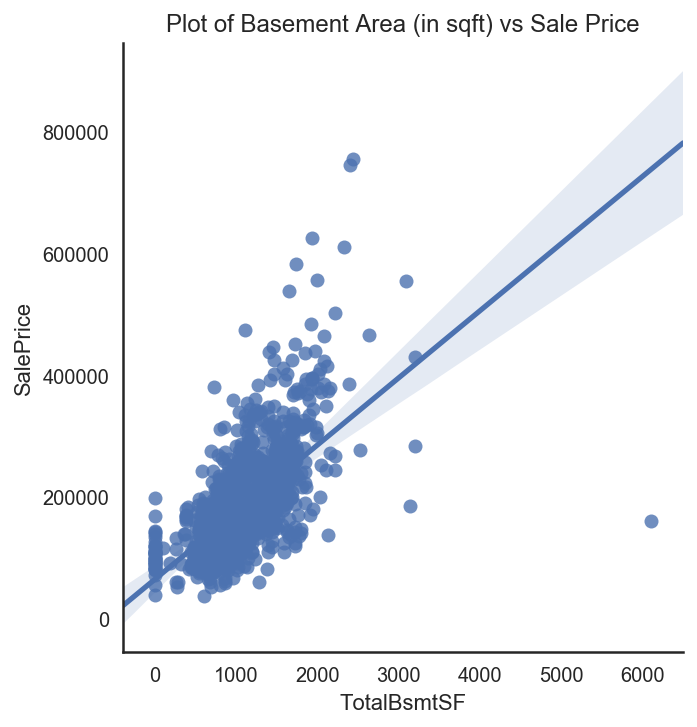

In [38]:
plt.figure(figsize=(1,1))
sns.lmplot('TotalBsmtSF', 'SalePrice', house_1)
plt.title('Plot of Basement Area (in sqft) vs Sale Price')

We see that the houses in our dataset have basement area till 6000 sqft. There are also houses with no basement. <br>
Generally, we see that a house bigger basement area will be priced higher. <br>
However, there are houses without basement priced higher than houses with basement.

Text(0.5,1,u'Plot of Pool Area (in sqft) vs Sale Price')

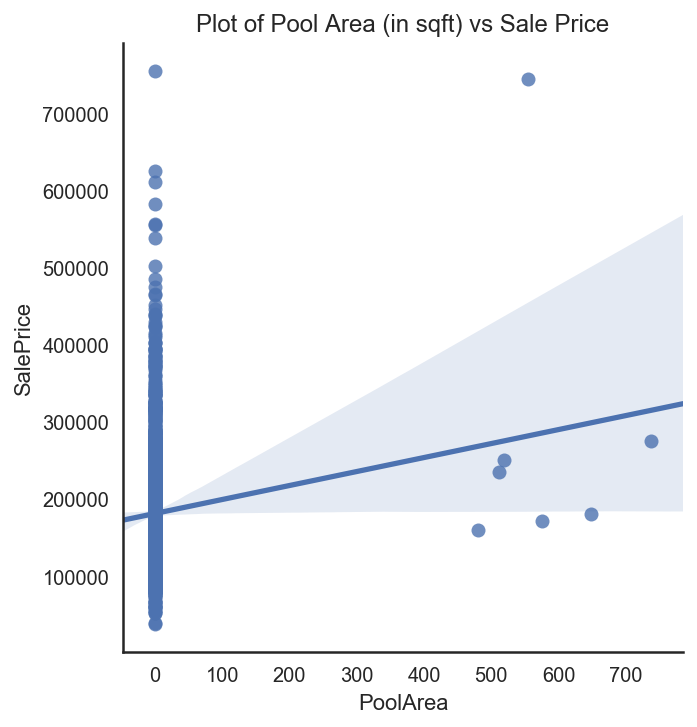

In [39]:
plt.figure(figsize=(5,5))
sns.lmplot('PoolArea', 'SalePrice', house_1)
plt.title('Plot of Pool Area (in sqft) vs Sale Price')

We see that the houses in our dataset have a pool area till 800 sqft. Most of the houses in the dataset do not have a pool.

We will split our dataset in train and test sets. <br> <br>
Train set: Houses sold before 2010 <br>
Test set: Houses sold in 2010 <br> <br>

Our target variable for these 2 sets would be SalePrice column for respective DFs.

In [40]:
# to filter based on Yrsold to split for test and prediction set

house_Yrb4_2010 = house_1[house_1['YrSold'] < 2010]
house_Yr_2010 = house_1[house_1['YrSold'] == 2010]
print house_Yrb4_2010.shape
print house_Yr_2010.shape

(1278, 141)
(172, 141)


In [41]:
house_Yrb4_2010.drop('YrSold', axis=1, inplace=True)
house_Yr_2010.drop('YrSold', axis=1, inplace=True)

C:\Users\Arsyad\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Arsyad\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
cols = list(house_Yrb4_2010.columns)
cols.remove('SalePrice')


y_train = house_Yrb4_2010['SalePrice']
X_train = house_Yrb4_2010.drop('SalePrice', axis=1)

y_test = house_Yr_2010['SalePrice']
X_test = house_Yr_2010.drop('SalePrice', axis=1)

Now that we have done our EDA and split our dataset into train and test sets, we will start with our modelling.

In [43]:
# importing all the sklearn modules

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

C:\Users\Arsyad\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [44]:
# we will standard scale our X_train and X_test before modelling.

ss = StandardScaler()

ss.fit(X_train)

Xs_train = pd.DataFrame(ss.transform(X_train), columns=X_train.columns.values)
Xs_test = pd.DataFrame(ss.transform(X_test), columns=X_train.columns.values)

# mm = MinMaxScaler()

# Xs_train = pd.DataFrame(mm.fit_transform(X_train), columns=X_train.columns.values)
# Xs_test = pd.DataFrame(mm.fit_transform(X_test), columns=X_test.columns.values)

In [45]:
# getting our base model out based on a simple Linear Regression and train/test split

lm = LinearRegression()
model = lm.fit(Xs_train, y_train)

print 'Score: ', model.score(Xs_test, y_test)
# print model.intercept_

Score:  -7.572391098119931e+23


We see that our score on the test set is -7.572. This shows that our model is overfitting on the train/test set.

### Running Lasso Reg

In [46]:
# lasso feature selection with house_age

optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(Xs_train, y_train)

print 'Optimal Lasso Alpha: ', optimal_lasso.alpha_

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv=10)

print 'lasso scores:', lasso_scores
print 'Mean lasso scores:', np.mean(lasso_scores)

Optimal Lasso Alpha:  597.308125651647
lasso scores: [0.89413357 0.84036798 0.86635053 0.74790147 0.83037925 0.72443965
 0.89471798 0.81706567 0.48035492 0.83856054]
Mean lasso scores: 0.7934271554432563


In [47]:
#Lasso feature variable selection

lasso = lasso.fit(Xs_train, y_train)
lasso_coefs = pd.DataFrame({'var': X_train.columns,
                          'coef':lasso.coef_,
                          'abs_coef':np.abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', ascending=False)

,abs_coef,coef,var
12,28450.694335,28450.694335,GrLivArea
67,15509.485684,-15509.485684,BsmtQual_Gd
69,14840.022112,-14840.022112,BsmtQual_TA
91,11068.284482,11068.284482,Neighborhood_NridgHt
16,9327.312417,9327.312417,GarageCars
90,8961.987581,8961.987581,Neighborhood_NoRidge
20,7463.476740,-7463.476740,house_age
21,7303.469403,7303.469403,YearRemodAdd
97,7255.002664,7255.002664,Neighborhood_StoneBr
7,5349.436226,-5349.436226,KitchenAbvGr


In [48]:
# pulling out columns with coefficient higher than 0

lasso_columns = list(lasso_coefs[lasso_coefs.abs_coef > 0]['var'])
lasso_columns

['HalfBath',
 'BsmtFullBath',
 'BedroomAbvGr',
 'TotalBsmtSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'FullBath',
 'GrLivArea',
 'LotArea',
 'GarageCars',
 'MasVnrArea',
 'BsmtFinSF1',
 'house_age',
 'YearRemodAdd',
 'WoodDeckSF',
 'OpenPorchSF',
 '3SsnPorch',
 'ScreenPorch',
 'Fireplaces',
 'MSSubClass_160',
 'MSSubClass_20',
 'Street_Pave',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'Condition2_PosA',
 'Condition2_PosN',
 'Foundation_PConc',
 'Foundation_Slab',
 'MSZoning_RM',
 'BldgType_Twnhs',
 'BldgType_TwnhsE',
 'BsmtQual_Fa',
 'BsmtQual_Gd',
 'BsmtQual_Nil',
 'BsmtQual_TA',
 'GarageType_BuiltIn',
 'GarageType_CarPort',
 'GarageType_Nil',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge

### RFECV Feature Selection

In [49]:
# RFECV feature selection

from sklearn.feature_selection import RFECV


selector = RFECV(lm, step=1, cv=10)
selector = selector.fit(Xs_train, y_train)


# print selector.support_
# print selector.ranking_

In [50]:
rfecv_columns = np.array(cols)[selector.support_]
rfecv_columns

array(['BsmtFullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'FullBath',
       'GrLivArea', 'LotArea', 'GarageCars', 'MasVnrArea', 'BsmtFinSF1',
       'YearRemodAdd', 'ScreenPorch', 'Fireplaces', 'MSSubClass_20',
       'Condition2_PosN', 'Condition2_RRAe', 'BldgType_Twnhs',
       'BldgType_TwnhsE', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_Nil',
       'BsmtQual_TA', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_Mitchel', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_StoneBr', 'LotShape_IR3',
       'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone',
       'RoofStyle_Shed'], dtype='|S20')

### K Best Feature Selection

In [51]:
# select K Best feature selection

from sklearn.feature_selection import SelectKBest, f_regression

# Build the selector — we'll build one with each score type.
skb_f = SelectKBest(f_regression, k=10)

# Train the selector on the data.
skb_f.fit(Xs_train, y_train)

# Examine the results.
kbest = pd.DataFrame([cols, list(skb_f.scores_)], 
                     index=['feature','f_regression']).T.sort_values('f_regression', ascending=False)

kbest.sort_values('f_regression', ascending=False)

,feature,f_regression
12,GrLivArea,1284
16,GarageCars,894.937
13,GarageArea,844.791
5,TotalBsmtSF,731.737
10,1stFlrSF,711.931
11,FullBath,590.937
9,TotRmsAbvGrd,495.105
20,house_age,454.294
21,YearRemodAdd,438.748
55,Foundation_PConc,387.207


In [52]:
# we will take the top 50 features

kbest_columns = kbest.feature.values[:50]
kbest_columns

array(['GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF',
       'FullBath', 'TotRmsAbvGrd', 'house_age', 'YearRemodAdd',
       'Foundation_PConc', 'Fireplaces', 'MasVnrArea', 'BsmtQual_TA',
       'Neighborhood_NridgHt', 'MSSubClass_60', 'MasVnrType_None',
       'BsmtFinSF1', 'GarageType_Detchd', 'Neighborhood_NoRidge',
       'MasVnrType_Stone', 'OpenPorchSF', 'WoodDeckSF',
       'GarageType_Attchd', 'Foundation_CBlock', '2ndFlrSF',
       'MSZoning_RM', 'HalfBath', 'LotShape_Reg', 'LotArea',
       'HouseStyle_2Story', 'MSSubClass_30', 'RoofStyle_Hip',
       'GarageType_Nil', 'GarageType_BuiltIn', 'MSZoning_RL',
       'BsmtQual_Gd', 'BsmtFullBath', 'RoofStyle_Gable', 'LotFrontage',
       'Neighborhood_StoneBr', 'Neighborhood_NAmes',
       'Neighborhood_OldTown', 'MasVnrType_BrkFace',
       'Neighborhood_Edwards', 'BedroomAbvGr', 'MSSubClass_50',
       'Neighborhood_BrkSide', 'BsmtQual_Nil', 'Neighborhood_Somerst',
       'BsmtQual_Fa'], dtype=object)

In [53]:
# selecting the best features (based on lasso, rfecv and kbest)

rfecv_scores = cross_val_score(lm, Xs_train[rfecv_columns], y_train, cv=10)
print 'Mean rfecv: ', np.mean(rfecv_scores)
print 'Std rfecv: ', np.std(rfecv_scores),'\n'

kbest_scores = cross_val_score(lm, Xs_train[kbest_columns], y_train, cv=10)
print 'Mean kbest: ', np.mean(kbest_scores)
print 'Std kbest: ', np.std(kbest_scores),'\n'


# lasso_scores = cross_val_score(lm, Xs_train[lasso_columns], y_train, cv=10)
# print 'Mean lasso: ', np.mean(lasso_scores)
# print 'Std lasso: ', np.std(lasso_scores),'\n'

# same as above codes for lasso. We can use the codes below to take features that have more than coefficient of 0.
print 'Mean Lasso: ', np.mean(lasso_scores)
print 'Std Lasso: ', np.std(lasso_scores),'\n'

Mean rfecv:  0.7961710912801176
Std rfecv:  0.08994897457645287 

Mean kbest:  0.7874922702269433
Std kbest:  0.1098098968045542 

Mean Lasso:  0.7934271554432563
Std Lasso:  0.11693169939638862 



In [54]:
# linear regression with lasso features due to best score based on our train set

# fitting our lm model into Xs_train with lasso columns
model_lasso = lm.fit(Xs_train[lasso_columns], y_train)

# predicting our fitted model into Xs_test set
prediction_lasso = model_lasso.predict(Xs_test[lasso_columns])


# score for model

from sklearn.metrics import r2_score

score_lasso = r2_score(y_test, prediction_lasso)
score_lasso

0.8695359033568508

Our model here performs better on the test set at R2 (accuracy) score of 0.869 with the revised columns based on LassoCV selection. We will plot Sale Price vs Predicted Price chart to visualize how on our prediction. We will also put them into a DF and look at the difference of these 2 columns.

Text(0.5,1,u'Plot of Sale Price vs Predicted Price')

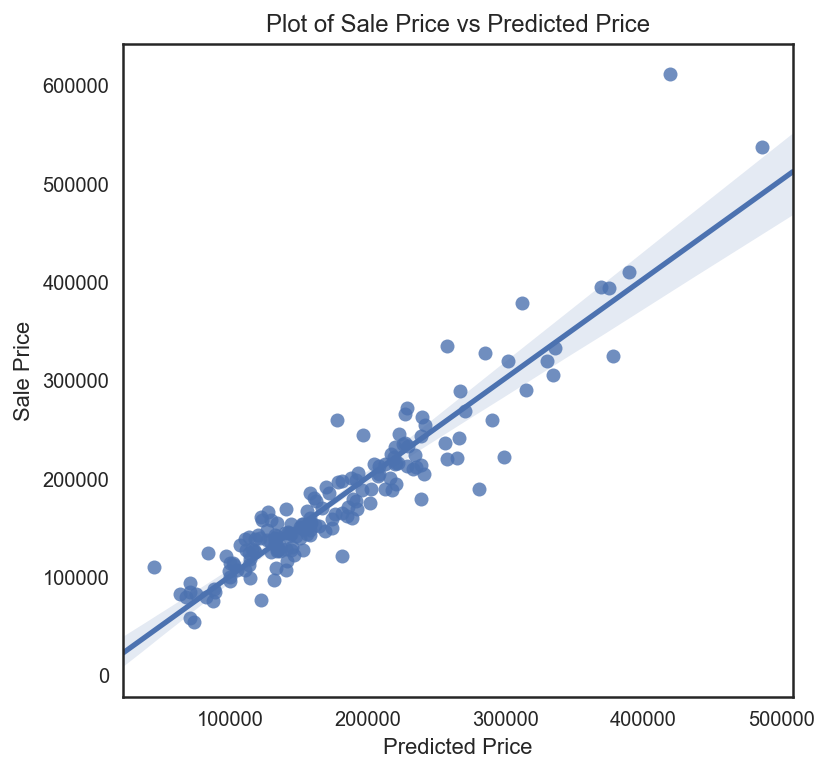

In [55]:
plt.figure(figsize=(6,6))
sns.regplot(prediction_lasso, y_test)
plt.xlabel('Predicted Price')
plt.ylabel('Sale Price')
plt.title('Plot of Sale Price vs Predicted Price')

In [56]:
# creating a DF for SalePrice(y_test), predicted price and difference of the 2 columns

prediction_test = pd.DataFrame({'predicted_price': prediction_lasso,
                          'y_test': y_test})
prediction_test['y_test - predicted_price'] = prediction_test['y_test'] - prediction_test['predicted_price']
prediction_test.head()

,predicted_price,y_test,y_test - predicted_price
16,152864.192355,149000,-3864.192355
24,143936.172113,154000,10063.827887
26,132303.554729,134800,2496.445271
27,334092.206368,306000,-28092.206368
33,181376.348522,165500,-15876.348522


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [57]:
# getting the non-fixed feature columns

non_fixed_feat = house_clean.drop(fixed_feat, axis=1)
non_fixed_feat.columns.values

array(['YearBuilt', 'BsmtUnfSF', 'LowQualFinSF', 'MoSold', 'YrSold',
       'SalePrice', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual',
       'ExterCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'SaleType', 'SaleCondition', 'OverallQual', 'OverallCond'],
      dtype=object)

In [58]:
# to filter out the ord categorical features

def change_to_string(col):
    non_fixed_feat[col] = non_fixed_feat[col].apply(lambda x: str(x))                                         

In [59]:
change_to_string('OverallQual')
change_to_string('OverallCond')

In [61]:
non_fixed_feat.drop('YearBuilt', axis=1, inplace=True)

non_fixed_feat.columns.values

array(['BsmtUnfSF', 'LowQualFinSF', 'MoSold', 'YrSold', 'SalePrice',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType',
       'SaleCondition', 'OverallQual', 'OverallCond'], dtype=object)

In [62]:
non_fixed_feat_dummy = pd.get_dummies(non_fixed_feat, drop_first=True)
non_fixed_feat_dummy.shape

(1450, 149)

In [63]:
# splitting to train and test set for non-fixed feature

house_Yrb4_2010_q2 = non_fixed_feat_dummy[non_fixed_feat_dummy['YrSold'] < 2010]
house_Yr_2010_q2 = non_fixed_feat_dummy[non_fixed_feat_dummy['YrSold'] == 2010]

print house_Yrb4_2010_q2.shape
print house_Yr_2010_q2.shape

(1278, 149)
(172, 149)


In [64]:
pred_train = model_lasso.predict(Xs_train[lasso_columns])
prediction_train = pd.DataFrame({'y_train': y_train,
                                'pred_y_train': pred_train})

prediction_train['y_train - pred_y_train'] = prediction_train['y_train'] - prediction_train['pred_y_train']

In [65]:
house_Yr_2010_q2 = pd.concat([house_Yr_2010_q2, prediction_test], axis=1)

house_Yrb4_2010_q2 = pd.concat([house_Yrb4_2010_q2, prediction_train], axis=1)

In [69]:
house_Yr_2010_q2.head()

,BsmtUnfSF,LowQualFinSF,MoSold,YrSold,SalePrice,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,...,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,predicted_price,y_test,y_test - predicted_price
16,426,0,3,2010,149000,1,0,0,0,0,...,0,0,0,0,1,0,0,152864.192355,149000,-3864.192355
24,204,0,5,2010,154000,1,0,0,0,0,...,0,0,0,0,0,1,0,143936.172113,154000,10063.827887
26,180,0,5,2010,134800,1,0,0,0,0,...,0,0,0,0,1,0,0,132303.554729,134800,2496.445271
27,486,0,5,2010,306000,1,0,0,0,0,...,0,0,1,0,0,0,0,334092.206368,306000,-28092.206368
33,380,0,4,2010,165500,1,0,0,0,0,...,0,0,1,0,0,0,0,181376.348522,165500,-15876.348522


In [70]:
# splitting to train and test set for non-fixed feature


y_train_q2 = house_Yrb4_2010_q2['y_train - pred_y_train']
X_train_q2 = house_Yrb4_2010_q2[house_Yrb4_2010_q2['YrSold'] < 2010].drop(['YrSold', 'SalePrice', 'y_train - pred_y_train',
                                                                          'pred_y_train', 'y_train'], axis=1)

y_test_q2 = house_Yr_2010_q2['y_test - predicted_price']
X_test_q2 = house_Yr_2010_q2[house_Yr_2010_q2['YrSold'] == 2010].drop(['YrSold', 'SalePrice', 'y_test - predicted_price',
                                                                          'predicted_price', 'y_test'], axis=1)

cols_nf = list(X_train_q2.columns)

print 'X_train shape: ', X_train_q2.shape
print 'y_train shape: ', y_train_q2.shape
print 'X_test shape: ', X_test_q2.shape
print 'y_test shape: ', y_test_q2.shape

X_train shape:  (1278, 147)
y_train shape:  (1278L,)
X_test shape:  (172, 147)
y_test shape:  (172L,)


In [72]:
# scaling the train and test set

ss = StandardScaler()

ss.fit(X_train_q2)

Xs_train_q2 = pd.DataFrame(ss.transform(X_train_q2), columns=X_train_q2.columns.values)
Xs_test_q2 = pd.DataFrame(ss.transform(X_test_q2), columns=X_train_q2.columns.values)

# Xs_train1 = pd.DataFrame(mm.fit_transform(X_train1), columns=X_train1.columns.values)
# Xs_test1 = pd.DataFrame(mm.fit_transform(X_test1), columns=X_train1.columns.values)

In [74]:
# res -> residual
# scoring for non-fixed features for lin reg (baseline)

lm = LinearRegression()
model_nf = lm.fit(Xs_train_q2, y_train_q2)

print lm.score(Xs_test_q2, y_test_q2)
print model_nf.intercept_

-3.541388500632832e+22
-1.8443800591453674


### Lasso 

In [97]:
# lasso feature selection


optimal_lasso_nf = LassoCV(n_alphas=500, cv=10)
optimal_lasso_nf.fit(Xs_train_q2, y_train_q2)

print 'Optimal Lasso Alpha for non-fixed features: ', optimal_lasso_nf.alpha_, '\n'

lasso_nf = Lasso(alpha=optimal_lasso_nf.alpha_)

lasso_scores_nf = cross_val_score(lasso_nf, Xs_train_q2, y_train_q2, cv=10)

print 'lasso scores for non-fixed features:', lasso_scores_nf, '\n'
print 'Mean lasso scores for non-fixed features:', np.mean(lasso_scores_nf)

Optimal Lasso Alpha for non-fixed features:  1503.4292471355138 

lasso scores for non-fixed features: [-0.02010282  0.16093627  0.14492801 -0.09384769  0.19626209  0.07643469
  0.02492926  0.06932794  0.00820017 -0.36206247] 

Mean lasso scores for non-fixed features: 0.020500543928076854


In [77]:
# Lasso feature selection/variable for non-fixed features

lasso_nf = lasso_nf.fit(Xs_train_q2, y_train_q2)
lasso_coefs_nf = pd.DataFrame({'var_nf': Xs_train_q2.columns,
                          'coef_nf':lasso_nf.coef_,
                          'abs_coef_nf':np.abs(lasso_nf.coef_)})
lasso_coefs_nf.sort_values('abs_coef_nf', ascending=False)

,abs_coef_nf,coef_nf,var_nf
111,3349.180285,-3349.180285,PoolQC_Gd
130,3310.047291,3310.047291,OverallQual_10
9,3170.851168,3170.851168,RoofMatl_WdShngl
89,2595.600963,2595.600963,Functional_Typ
12,1827.168161,1827.168161,Exterior1st_BrkFace
138,1641.135337,1641.135337,OverallQual_9
140,1529.801125,-1529.801125,OverallCond_3
50,1209.330745,1209.330745,BsmtExposure_Gd
142,1041.749066,-1041.749066,OverallCond_5
53,688.701324,-688.701324,BsmtExposure_No


In [79]:
lasso_columns_nf = list(lasso_coefs_nf[lasso_coefs_nf.abs_coef_nf > 0]['var_nf'])
lasso_columns_nf

['RoofMatl_Membran',
 'RoofMatl_WdShngl',
 'Exterior1st_BrkFace',
 'Exterior2nd_CmentBd',
 'Exterior2nd_ImStucc',
 'BsmtExposure_Gd',
 'BsmtExposure_No',
 'Functional_Typ',
 'GarageFinish_RFn',
 'PoolQC_Gd',
 'OverallQual_10',
 'OverallQual_9',
 'OverallCond_3',
 'OverallCond_4',
 'OverallCond_5',
 'OverallCond_7',
 'OverallCond_9']

### RFECV

In [80]:
# RFECV feature selection for non-fixed features

selector_nf = RFECV(lm, step=1, cv=10)
selector_nf = selector_nf.fit(Xs_train_q2, y_train_q2)

# print selector.support_
# print selector.ranking_

In [81]:
# getting the RFECV non-fixed features

rfecv_columns_nf = np.array(cols_nf)[selector_nf.support_]
rfecv_columns_nf

array(['OverallCond_3'], dtype='|S21')

### KBest

In [82]:
# select k best feature

# Build the selector — we'll build one with each score type.
skb_f_nf = SelectKBest(f_regression, k=10)
# skb_chi2 = SelectKBest(chi2, k=10)

# Train the selector on the data.
skb_f_nf.fit(Xs_train_q2, y_train_q2)
# skb_chi2.fit(Xs_train, y_train)


# Examine the results.
kbest_nf = pd.DataFrame([cols_nf, list(skb_f_nf.scores_)], 
                     index=['feature_nf','f_reg_nf']).T.sort_values('f_reg_nf', ascending=False)

# # Examine the results.
# kbest = pd.DataFrame([cols, list(skb_f.scores_), list(skb_chi2.scores_)], 
#                      index=['feature','f_classif','chi2 score']).T.sort_values('f_classif', ascending=False)
kbest_nf

C:\Users\Arsyad\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: invalid value encountered in divide
  corr /= X_norms
C:\Users\Arsyad\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Arsyad\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Arsyad\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,feature_nf,f_reg_nf
9,RoofMatl_WdShngl,50.2062
130,OverallQual_10,42.523
89,Functional_Typ,28.6549
111,PoolQC_Gd,27.2947
50,BsmtExposure_Gd,25.132
140,OverallCond_3,17.5516
138,OverallQual_9,16.691
53,BsmtExposure_No,16.1153
12,Exterior1st_BrkFace,15.8744
146,OverallCond_9,9.49545


In [116]:
kbest_columns_nf = kbest_nf.feature_nf.values[:25]
kbest_columns_nf

array(['RoofMatl_WdShngl', 'OverallQual_10', 'Functional_Typ',
       'PoolQC_Gd', 'BsmtExposure_Gd', 'OverallCond_3', 'OverallQual_9',
       'BsmtExposure_No', 'Exterior1st_BrkFace', 'OverallCond_9',
       'Exterior2nd_CmentBd', 'Exterior2nd_BrkFace', 'Functional_Min1',
       'BsmtFinType1_GLQ', 'Exterior1st_CemntBd', 'OverallCond_7',
       'Functional_Maj2', 'Functional_Min2', 'Exterior2nd_ImStucc',
       'SaleType_New', 'SaleCondition_Partial', 'OverallCond_4',
       'BsmtFinType1_Unf', 'SaleType_Con', 'KitchenQual_TA'], dtype=object)

In [117]:
# selecting the best model / features

rfecv_scores_nf = cross_val_score(lm, Xs_train_q2[rfecv_columns_nf], y_train_q2, cv=10)
print 'Mean rfecv non-fixed feat: ', np.mean(rfecv_scores_nf)
print 'Std rfecv non-fixed feat: ', np.std(rfecv_scores_nf),'\n'

kbest_scores_nf = cross_val_score(lm, Xs_train_q2[kbest_columns_nf], y_train_q2, cv=10)
print 'Mean kbest non-fixed feat: ', np.mean(kbest_scores_nf)
print 'Std kbest non-fixed feat: ', np.std(kbest_scores_nf),'\n'

print 'Mean Lasso non-fixed feat: ', np.mean(lasso_scores_nf)
print 'Std Lasso non-fixed feat: ', np.std(lasso_scores_nf),'\n'


base_scores_nf = cross_val_score(lm, Xs_train_q2, y_train_q2, cv=10)
print 'Mean baseline non-fixed feat: ', np.mean(base_scores_nf)
print 'Std baseline non-fixed feat: ', np.std(base_scores_nf)

Mean rfecv non-fixed feat:  -0.002154605499157891
Std rfecv non-fixed feat:  0.034110721308047466 

Mean kbest non-fixed feat:  -0.023824743299949457
Std kbest non-fixed feat:  0.24391561519396857 

Mean Lasso non-fixed feat:  0.020500543928076854
Std Lasso non-fixed feat:  0.15259710918577543 

Mean baseline non-fixed feat:  -9.8740299003122e+24
Std baseline non-fixed feat:  2.8648222113002594e+25


In [118]:
# linear regression with lasso features due to best score based on our train set

lm = LinearRegression()

# fitting our lm model into Xs_train with lasso columns
model_lasso = lm.fit(Xs_train_q2[lasso_columns_nf], y_train_q2)

# predicting our fitted model into Xs_test set
prediction_lasso_nf = model_lasso.predict(Xs_test_q2[lasso_columns_nf])


# score for model

from sklearn.metrics import r2_score

score_lasso_nf = r2_score(y_test_q2, prediction_lasso_nf)
score_lasso_nf

0.14588470877823623

price of house = est value of fixed features + est value of non-fixed features + external factors

- Based on the our model above, we can predict only about 14.5% of the residual Sale Price based on the non-fixed features. 
- We should have considered the value of a house based on the fixed and non-fixed features as they would work together to give a better estimated house price.
- Additionally, we should consider external factors such as macro-economic conditions of the country. These factors include interest rates and supply & demand of houses in the area as these would play a part in housing prices.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [164]:
house_clean_q3 = house_clean.copy()
house_clean_q3['SaleCondition'].value_counts()

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

We have an imbalance class issue. Our prediction will not be accurate if this imbalance class issue is not addressed.

In [165]:
# we will have to binarize encode the SaleCondition column.

house_clean_q3['if_abnormal'] = house_clean_q3['SaleCondition'].apply(lambda x: 1 if x == 'Abnorml' else 0)
print house_clean_q3['if_abnormal'].value_counts()
house_clean_q3.head()

0    1354
1      96
Name: if_abnormal, dtype: int64


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,if_abnormal
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,...,1,0,2,1,3,1,8,0,2,0
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,...,0,1,2,0,3,1,6,1,2,0
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,...,1,0,2,1,3,1,6,1,2,0
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,...,1,0,1,0,3,1,7,1,3,1
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,...,1,0,2,1,4,1,9,1,3,0


In [166]:
house_cat.columns

Index([u'MSZoning', u'Street', u'Alley', u'LotShape', u'LandContour',
       u'Utilities', u'LotConfig', u'LandSlope', u'Neighborhood',
       u'Condition1', u'Condition2', u'BldgType', u'HouseStyle', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinType2', u'Heating',
       u'HeatingQC', u'CentralAir', u'Electrical', u'KitchenQual',
       u'Functional', u'FireplaceQu', u'GarageType', u'GarageFinish',
       u'GarageQual', u'GarageCond', u'PavedDrive', u'PoolQC', u'Fence',
       u'SaleType', u'SaleCondition', u'MSSubClass', u'MiscFeature'],
      dtype='object')

In [167]:
# we will split the clean DF and dummy categorize the categorical non-numeric columns

house_cat_q3 = house_clean_q3[house_cat.drop('SaleCondition', axis=1).columns.values]
house_clean_q3.drop(house_cat_q3, axis=1, inplace=True)

house_cat_q3_dummy = pd.get_dummies(house_cat_q3, drop_first=True)
house_clean_q3 = pd.concat([house_clean_q3, house_cat_q3_dummy], axis=1)
house_clean_q3.drop('SaleCondition', axis=1, inplace=True)

In [182]:
# defining our x and y variable and splitting to train/test sets

y_q3 = house_clean_q3['if_abnormal']
x_q3 = house_clean_q3.drop('if_abnormal', axis=1)

X_train_q3, X_test_q3, y_train_q3, y_test_q3 = train_test_split(x_q3, y_q3, test_size=0.3, random_state=42)

In [185]:
# standard scaling the predictor features

ss = StandardScaler()

ss.fit(X_train_q3)

Xs_train_q3 = pd.DataFrame(ss.transform(X_train_q3), columns=X_train_q3.columns.values)
Xs_test_q3 = pd.DataFrame(ss.transform(X_test_q3), columns=X_train_q3.columns.values)

In [212]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from  sklearn.utils import resample

### Logistic Regression - class_weight='balanced

In [227]:
lr = LogisticRegression(class_weight='balanced')

param = {'C': [0.0001, 0.001, 0.01, 1, 10]}

grid_lr = GridSearchCV(lr, param, verbose=2, cv=10)

model_lr = grid_lr.fit(Xs_train_q3, y_train_q3)

model_lr.best_params_

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   12.6s finished


{'C': 10}

In [228]:
model_grid_lr = model_lr.best_estimator_
score_lr = model_grid_lr.score(Xs_test_q3, y_test_q3)

grid_pred_lr = model_grid_lr.predict(Xs_test_q3)


print 'Score: ', score_lr, '\n'

print 'Confusion Matrix: \n', confusion_matrix(y_test_q3, grid_pred_lr), '\n'
print 'Classification Report: \n', classification_report(y_test_q3, grid_pred_lr)

Score:  0.8505747126436781 

Confusion Matrix: 
[[362  45]
 [ 20   8]] 

Classification Report: 
             precision    recall  f1-score   support

          0       0.95      0.89      0.92       407
          1       0.15      0.29      0.20        28

avg / total       0.90      0.85      0.87       435



The Logistic Regression model gives us an accuracy of 0.85. However, we only get a recall and f1 score of 0.29 and 0.2 respectively for our minority class. This indicates that our model is able to predict only 29% recall for our minority class.

### Random Forest - class_weight='balanced

In [232]:
rfc = RandomForestClassifier(class_weight='balanced')

param = {'n_estimators': [15, 20, 25, 30, 35],
         'max_depth': [1, 2, 3, 4, 5]         
            }

grid_rfc = GridSearchCV(rfc, param, verbose=1, cv=10)

model_rfc = grid_rfc.fit(Xs_train_q3, y_train_q3)

model_rfc.best_params_

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   33.4s finished


{'max_depth': 5, 'n_estimators': 25}

In [233]:
model_grid_rfc = model_rfc.best_estimator_
score_rfc = model_grid_rfc.score(Xs_test_q3, y_test_q3)

grid_pred_rfc = model_grid_rfc.predict(Xs_test_q3)


print 'Score: ', score_rfc, '\n'

print 'Confusion Matrix: \n', confusion_matrix(y_test_q3, grid_pred_rfc), '\n'
print 'Classification Report: \n', classification_report(y_test_q3, grid_pred_rfc)

Score:  0.8551724137931035 

Confusion Matrix: 
[[363  44]
 [ 19   9]] 

Classification Report: 
             precision    recall  f1-score   support

          0       0.95      0.89      0.92       407
          1       0.17      0.32      0.22        28

avg / total       0.90      0.86      0.88       435



The Random Forest model gives us an accuracy of 0.85. However, we only get a recall and f1 score of 0.32 and 0.22 respectively for our minority class. We can see that this model is performing slightly better than the Logistic Regression model. However, the recall rate is still not good as it is worse than performing a random guess (at 50%).

We will try to upsample our train set next.

### Upsampling our train data set

In [238]:
# concatenating our X_train and y_train into a temp DF to upsample
train_temp = pd.concat([X_train_q3, y_train_q3], axis=1)
train_temp.if_abnormal.value_counts()

0    947
1     68
Name: if_abnormal, dtype: int64

In [239]:
# Separate majority and minority classes
df_majority = train_temp[train_temp.if_abnormal==0]
df_minority =  train_temp[train_temp.if_abnormal==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=947,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.if_abnormal.value_counts()

1    947
0    947
Name: if_abnormal, dtype: int64

In [240]:
# splitting the predictors and target

y_train_q3_up = df_upsampled['if_abnormal']
X_train_q3_up = df_upsampled.drop('if_abnormal', axis=1)

In [241]:
# standard scaling the upsampled X_train and X_test data sets

ss = StandardScaler()

ss.fit(X_train_q3_up)

Xs_train_q3_up = pd.DataFrame(ss.transform(X_train_q3_up), columns=X_train_q3_up.columns.values)
Xs_test_q3_up = pd.DataFrame(ss.transform(X_test_q3), columns=X_train_q3_up.columns.values)

### Logistic Regression - upsampled

In [280]:
lr = LogisticRegression()

param = {'C': [0.0001, 0.001, 0.01, 1, 10]}

grid_lr = GridSearchCV(lr, param, verbose=1, cv=10)

model_lr = grid_lr.fit(Xs_train_q3_up, y_train_q3_up)

model_lr.best_params_

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   23.7s finished


{'C': 10}

In [281]:
model_grid_lr = model_lr.best_estimator_
score_lr = model_grid_lr.score(Xs_test_q3_up, y_test_q3)

grid_pred_lr = model_grid_lr.predict(Xs_test_q3_up)


print 'Score: ', score_lr, '\n'

print 'Confusion Matrix: \n', confusion_matrix(y_test_q3, grid_pred_lr), '\n'
print 'Classification Report: \n', classification_report(y_test_q3, grid_pred_lr)

Score:  0.8528735632183908 

Confusion Matrix: 
[[363  44]
 [ 20   8]] 

Classification Report: 
             precision    recall  f1-score   support

          0       0.95      0.89      0.92       407
          1       0.15      0.29      0.20        28

avg / total       0.90      0.85      0.87       435



### Random Forest - upsampled

In [309]:
rfc = RandomForestClassifier()

param = {'n_estimators': [15, 20, 25, 30, 35],
         'max_depth': [1, 2, 3, 4, 5]         
            }

grid_rfc = GridSearchCV(rfc, param, verbose=1, cv=10)

model_rfc = grid_rfc.fit(Xs_train_q3_up, y_train_q3_up)

model_rfc.best_params_

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   38.8s finished


{'max_depth': 5, 'n_estimators': 25}

In [310]:
model_grid_rfc = model_rfc.best_estimator_
score_rfc = model_grid_rfc.score(Xs_test_q3_up, y_test_q3)

grid_pred_rfc = model_grid_rfc.predict(Xs_test_q3_up)


print 'Score: ', score_rfc, '\n'

print 'Confusion Matrix: \n', confusion_matrix(y_test_q3, grid_pred_rfc), '\n'
print 'Classification Report: \n', classification_report(y_test_q3, grid_pred_rfc)

Score:  0.8114942528735632 

Confusion Matrix: 
[[345  62]
 [ 20   8]] 

Classification Report: 
             precision    recall  f1-score   support

          0       0.95      0.85      0.89       407
          1       0.11      0.29      0.16        28

avg / total       0.89      0.81      0.85       435



### Predicting with top 10 features

We will try to predict using the top 10 features for the 2 models above and upsampling them.

#### Logistic Regression upsampled with top 10 features

In [335]:
# getting the top 10 features for Logistic Regression

lrcv_coef = [item for sublist in model_grid_lr.coef_ for item in sublist]
feat = []
for feature in zip(list(Xs_train_q3_up.columns.values), lrcv_coef):
    feat.append(feature)
    
feat_df_lrcv = pd.DataFrame(feat, columns=['Feature', 'Coef'])
feat_df_lrcv = feat_df_lrcv.sort_values('Coef', ascending=False).head(10)
feat_df_lrcv

,Feature,Coef
35,MSSubClass,4.535804
128,Exterior1st_VinylSd,4.400182
209,Functional_Typ,4.128537
10,2ndFlrSF,3.640600
54,LandSlope_Sev,3.630599
145,Exterior2nd_Wd Shng,3.575714
71,Neighborhood_OldTown,3.448880
24,OverallQual,3.416748
232,GarageCond_Po,3.076610
53,LandSlope_Mod,2.881026


In [336]:
# splitting to train/test set based on the top 10 features of Logistic Regression
X_train_q3_2, X_test_q3_2, y_train_q3_2, y_test_q3_2 = train_test_split(x_q3[feat_df_lrcv.Feature.values], y_q3, test_size=0.3, random_state=42)


# concatenating our X_train and y_train into a temp DF to upsample
train_temp_2 = pd.concat([X_train_q3_2, y_train_q3_2], axis=1)
train_temp_2.if_abnormal.value_counts()

0    947
1     68
Name: if_abnormal, dtype: int64

In [337]:
# Separate majority and minority classes
df_majority_2 = train_temp_2[train_temp_2.if_abnormal==0]
df_minority_2 =  train_temp_2[train_temp_2.if_abnormal==1]
 
# Upsample minority class
df_minority_upsampled_2 = resample(df_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=947,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled_2 = pd.concat([df_majority_2, df_minority_upsampled_2])
 
# Display new class counts
df_upsampled_2.if_abnormal.value_counts()

1    947
0    947
Name: if_abnormal, dtype: int64

In [338]:
# splitting the predictors and target

y_train_q3_up_2 = df_upsampled_2['if_abnormal']
X_train_q3_up_2 = df_upsampled_2.drop('if_abnormal', axis=1)

In [339]:
# standard scaling the upsampled X_train and X_test data sets

ss = StandardScaler()

ss.fit(X_train_q3_up_2)

Xs_train_q3_up_2 = pd.DataFrame(ss.transform(X_train_q3_up_2), columns=X_train_q3_up_2.columns.values)
Xs_test_q3_up_2 = pd.DataFrame(ss.transform(X_test_q3_2), columns=X_train_q3_up_2.columns.values)

In [340]:
lr_2 = LogisticRegression()

param = {'C': [0.0001, 0.001, 0.01, 1, 10]}

grid_lr_2 = GridSearchCV(lr_2, param, verbose=1, cv=10)

model_lr_2 = grid_lr_2.fit(Xs_train_q3_up_2, y_train_q3_up_2)

model_lr_2.best_params_

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished


{'C': 1}

In [341]:
model_grid_lr_2 = model_lr_2.best_estimator_
score_lr_2 = model_grid_lr_2.score(Xs_test_q3_up_2, y_test_q3_2)

grid_pred_lr_2 = model_grid_lr_2.predict(Xs_test_q3_up_2)


print 'Score: ', score_lr_2, '\n'

print 'Confusion Matrix: \n', confusion_matrix(y_test_q3_2, grid_pred_lr_2), '\n'
print 'Classification Report: \n', classification_report(y_test_q3_2, grid_pred_lr_2)

Score:  0.6459770114942529 

Confusion Matrix: 
[[267 140]
 [ 14  14]] 

Classification Report: 
             precision    recall  f1-score   support

          0       0.95      0.66      0.78       407
          1       0.09      0.50      0.15        28

avg / total       0.89      0.65      0.74       435



#### Random Forest upsampled with top 10 features

In [342]:
# checking for features

feat = []
for feature in zip(Xs_train_q3_up.columns.values, model_grid_rfc.feature_importances_):
    feat.append(feature)
    
feat_df_rfc = pd.DataFrame(feat, columns=['Feature', 'Value'])
feat_df_rfc = feat_df_rfc.sort_values('Value', ascending=False).head(10)
feat_df_rfc

,Feature,Value
3,YearRemodAdd,0.131370
6,BsmtFinSF2,0.125641
11,LowQualFinSF,0.124612
0,LotFrontage,0.090152
14,WoodDeckSF,0.086198
10,2ndFlrSF,0.074614
13,GarageArea,0.067504
1,LotArea,0.061466
8,TotalBsmtSF,0.056647
9,1stFlrSF,0.046031


In [343]:
# splitting to train/test set based on the top 10 features of Logistic Regression
X_train_q3_2, X_test_q3_2, y_train_q3_2, y_test_q3_2 = train_test_split(x_q3[feat_df_rfc.Feature.values], y_q3, test_size=0.3, random_state=42)


# concatenating our X_train and y_train into a temp DF to upsample
train_temp_2 = pd.concat([X_train_q3_2, y_train_q3_2], axis=1)
train_temp_2.if_abnormal.value_counts()

0    947
1     68
Name: if_abnormal, dtype: int64

In [344]:
# Separate majority and minority classes
df_majority_2 = train_temp_2[train_temp_2.if_abnormal==0]
df_minority_2 =  train_temp_2[train_temp_2.if_abnormal==1]
 
# Upsample minority class
df_minority_upsampled_2 = resample(df_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=947,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled_2 = pd.concat([df_majority_2, df_minority_upsampled_2])
 
# Display new class counts
df_upsampled_2.if_abnormal.value_counts()

1    947
0    947
Name: if_abnormal, dtype: int64

In [345]:
# splitting the predictors and target

y_train_q3_up_2 = df_upsampled_2['if_abnormal']
X_train_q3_up_2 = df_upsampled_2.drop('if_abnormal', axis=1)

In [346]:
# standard scaling the upsampled X_train and X_test data sets

ss = StandardScaler()

ss.fit(X_train_q3_up_2)

Xs_train_q3_up_2 = pd.DataFrame(ss.transform(X_train_q3_up_2), columns=X_train_q3_up_2.columns.values)
Xs_test_q3_up_2 = pd.DataFrame(ss.transform(X_test_q3_2), columns=X_train_q3_up_2.columns.values)

In [347]:
rfc = RandomForestClassifier()

param = {'n_estimators': [15, 20, 25, 30, 35],
         'max_depth': [1, 2, 3, 4, 5]         
            }

grid_rfc = GridSearchCV(rfc, param, verbose=1, cv=10)

model_rfc = grid_rfc.fit(Xs_train_q3_up_2, y_train_q3_up_2)

model_rfc.best_params_

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   35.1s finished


{'max_depth': 5, 'n_estimators': 20}

In [348]:
model_grid_rfc = model_rfc.best_estimator_
score_rfc = model_grid_rfc.score(Xs_test_q3_up_2, y_test_q3_2)

grid_pred_rfc = model_grid_rfc.predict(Xs_test_q3_up_2)


print 'Score: ', score_rfc, '\n'

print 'Confusion Matrix: \n', confusion_matrix(y_test_q3_2, grid_pred_rfc), '\n'
print 'Classification Report: \n', classification_report(y_test_q3_2, grid_pred_rfc)

Score:  0.7379310344827587 

Confusion Matrix: 
[[308  99]
 [ 15  13]] 

Classification Report: 
             precision    recall  f1-score   support

          0       0.95      0.76      0.84       407
          1       0.12      0.46      0.19        28

avg / total       0.90      0.74      0.80       435



### Conclusion

We see that our upsampled Logistic Regression with top 10 feature selection performed better compared to the other models. The model is able to perform better at recall rate of 0.50 for the minority class with True Positive at 14 counts. <br> On the other hand, our upsampled Random Forest with top 10 feature selection has lesser False (Positive and Negative) counts. <br>The business will have to advise which model to select moving foward.